## Import Libraries

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV,StratifiedKFold

## Data Reading

In [255]:
data_dir = '/content/drive/MyDrive/heart_disease_ml/heart_statlog_cleveland_hungary_final.csv'

In [256]:
data = pd.read_csv(data_dir)

In [257]:
data.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [258]:
data.shape

(1190, 12)

## Preprocessing && EDA

### Data Cleaning

In [259]:
data.info() # no null samples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [260]:
data.isnull().sum()

,0
age,0
sex,0
chest pain type,0
resting bp s,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


NX: các mẫu dữ liệu không bị thiếu, nếu thiếu thì sử dụng kĩ thuật như: loại bỏ, thay thế, gắn cờ hoặc phân tích riêng




In [261]:
duplicates = data.duplicated().sum()
print(f"Số lượng dòng trùng lặp: {duplicates}")

Số lượng dòng trùng lặp: 272


In [262]:
# check duplicated samples
duplicates = data[data.duplicated(keep=False)]

print("Các dòng trùng lặp hoàn toàn:")
duplicates

Các dòng trùng lặp hoàn toàn:


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
90,49,0,2,110,208,0,0,160,0,0.0,1,0
163,49,0,2,110,208,0,0,160,0,0.0,1,0
556,58,1,3,150,219,0,1,118,1,0.0,2,1
604,58,1,3,150,219,0,1,118,1,0.0,2,1
617,70,1,4,130,322,0,2,109,0,2.4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,42,1,3,130,180,0,0,150,0,0.0,1,0
1157,61,1,4,140,207,0,2,138,1,1.9,1,1
1158,66,1,4,160,228,0,2,138,0,2.3,1,0
1159,46,1,4,140,311,0,0,120,1,1.8,2,1


In [263]:
# remove duplicated samples
data = data.drop_duplicates()

In [264]:
data.shape

(918, 12)

NX: dữ liệu 1190 mẫu giảm còn 918 mẫu vì trùng lặp


In [265]:
# summary statistic
data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,3.251634,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,1.636166,0.553377
std,9.432617,0.407701,0.931031,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.609341,0.497414
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


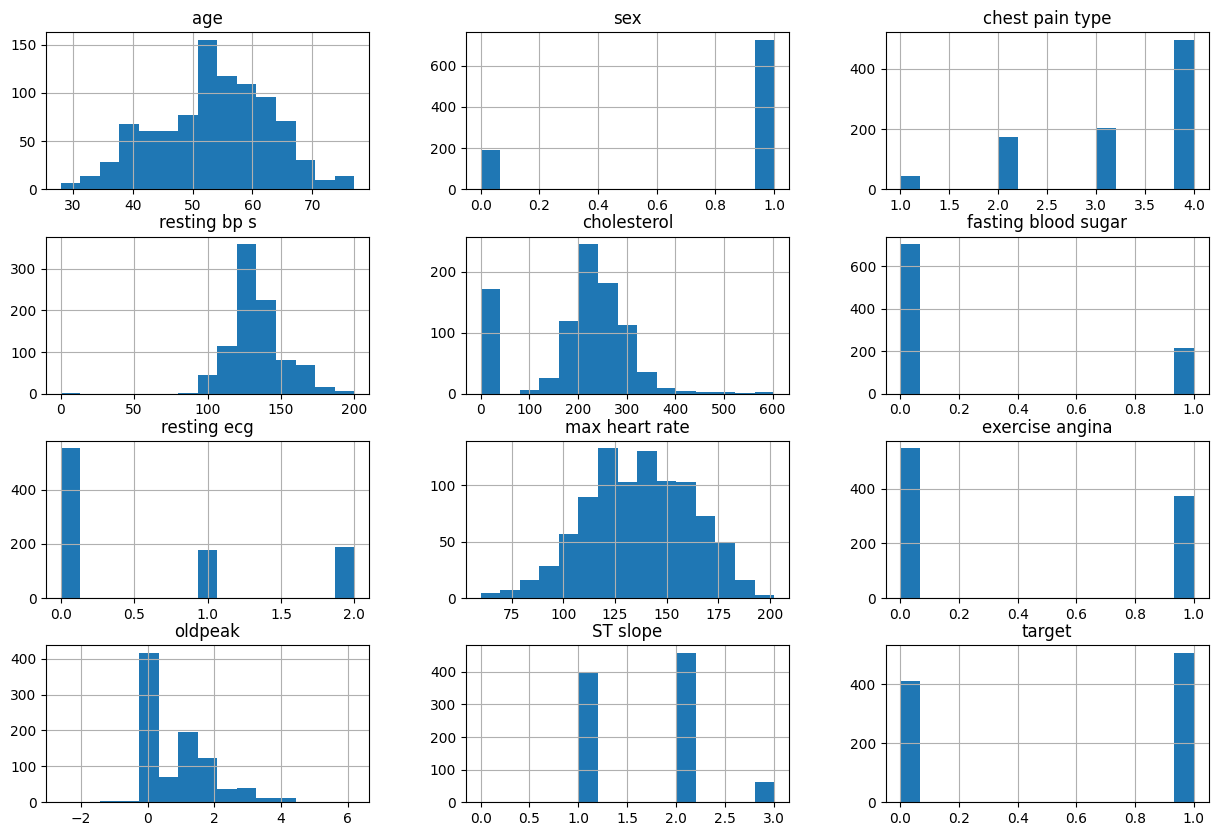

In [266]:
# understanding columns attributes
data.hist(bins=15, figsize=(15, 10))
plt.show()



1.   age: chạy từ 28 đến 77
2.   sex: 1 = nam, 0 = nữ
3.   chest pain type: kiểu đau ngực: 1 = đau điển hình, 2 = đau ngực không điển hình, 3 = đau không phải đau thắt ngực, 4 = không có triệu chứng
4.   !resting bp s: huyết áp khi nghỉ ngơi: 0 -> 200 mm/Hg
5.   !cholesterol: nồng độ cholesterol: 0 -> 603 mg/dl
6.   fasting blood sugar: lượng đường trong máu lúc đói: >120mg/dl = 1 else 0
7.   resting ecg: kết quả điện tâm đồ khi nghỉ ngơi: 0 = bình thường , 1 = có bất thường sóng ST-T, 2 = có khả năng hoặc chắc chắn tăng huyết áp tâm thất trái theo tiêu chuẩn Estes
8.   max heart rate: 60 -> 202
9.   exercise angina: có bị đau thắt ngực khi tập thể dục không: 1 = có, 0 = không
10.  !old peak: đại diện cho sự thay đổi của đoạn ST trên điện tâm đồ sau khi thực hiện bài kiểm tra gắng sức.: -2.6 -> 6.2. oldpeak = ST at rest - ST after exercise.
11.  !ST slope: độ dốc của đoạn ST(ST là đoạn ST trong điện tâm đồ) đỉnh trong bài kiểm tra gắng sức: 1 = dốc lên, 2 = phẳng, 3 = dốc xuống
12.  target: 0 = bình thường, 1 = có bệnh
      





In [267]:
data["ST slope"].unique()

array([1, 2, 3, 0])

In [268]:
st_slope_counts = data['ST slope'].value_counts()
st_slope_counts

,count
ST slope,
2,459
1,395
3,63
0,1


NX: cột "st_slope" có giá trị 0 - mà theo dữ liệu cột
này chỉ có các giá trị nomial là 1,2,3, tức nó đang là invalid data. Xử lý bằng Hot Deck Immutation(Knn, chọn hàng tương tự nhất để thay thế)


In [269]:
def impute_invalid_st_slope(df, features, k_values=[1,3,5]):
    """
    Thay thế invalid values trong 'st_slope' sử dụng Hot Deck Immutation theo KNN

    Parameters:
        df (pd.DataFrame): đầu vào dữ liệu
        features (list): list các features
        k_values (list): list giá trị k để thử

    Returns:
        pd.DataFrame: DataFrame với st_slope imputed
    """

    df = df.copy()
    valid_df = df[df['ST slope'] != 0].copy()
    invalid_df = df[df['ST slope'] == 0].copy()

    if invalid_df.empty:
        print("No invalid 'st_slope' values found.")
        return df

    # Chuẩn hóa
    scaler = StandardScaler()
    X_valid = scaler.fit_transform(valid_df[features])
    X_invalid = scaler.transform(invalid_df[features])
    y_valid = valid_df['ST slope']

    # pred with each k
    predictions_by_k = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_valid, y_valid)
        preds = knn.predict(X_invalid)
        predictions_by_k[k] = preds
        print(f"k = {k}: predicted = {list(preds)}")

    predictions_array = np.array(list(predictions_by_k.values()))  # shape: (len(k_values), num_invalid)
    final_predictions = []

    for i in range(predictions_array.shape[1]):
        candidate_preds = predictions_array[:, i]
        best_pred = mode(candidate_preds, keepdims=False).mode
        final_predictions.append(best_pred)

    final_predictions = [int(p) for p in final_predictions]
    # Gán lại vào df gốc
    df.loc[df['ST slope'] == 0, 'ST slope'] = final_predictions

    print(f"\n Final imputation result for invalid rows: {final_predictions}")
    return df

In [270]:
features = [col for col in data.columns if col != 'target']

In [271]:
data = impute_invalid_st_slope(data, features, k_values=[1, 3, 5])

k = 1: predicted = [np.int64(1)]
k = 3: predicted = [np.int64(1)]
k = 5: predicted = [np.int64(1)]

 Final imputation result for invalid rows: [1]


Vậy 1 là giá trị được thay thế cho invalid value của feature 'st_slope'

In [272]:
data.shape

(918, 12)

Xử lý huyết áp khi nghỉ có giá trị 0 mm/HG và nồng độ cholesterol có giá trị 0
mg/dl - giá trị không hợp lệ - invalid data

In [273]:
# kiểm tra số lượng invalid data
invalid_bp = data[data['resting bp s'] == 0]
invalid_chol = data[data['cholesterol'] == 0]
print(f"Số giá trị ở 'resting bp' = 0: {len(invalid_bp)}")
print(f"Số giá trị ở 'cholesterol' = 0: {len(invalid_chol)}")

Số giá trị ở 'resting bp' = 0: 1
Số giá trị ở 'cholesterol' = 0: 172


In [274]:
def impute_numeric_column_knn_multi_k(df, target_col, k_list=[1, 3, 5]):
    """
    Thay thế các giá trị 0 (invalid) trong target_col bằng Hot Deck Imputation sử dụng KNN.
    Dự đoán với nhiều giá trị k, sau đó lấy median (trung vị) của các dự đoán làm giá trị cuối cùng.

    Parameters:
        df (pd.DataFrame): Dữ liệu đầu vào
        target_col (str): Cột cần dự đoán (ví dụ: 'chol', 'resting bp s')
        k_list (list): Danh sách giá trị k để thử (ví dụ: [1, 3, 5])

    Returns:
        pd.DataFrame: Dữ liệu với target_col đã được thay thế ở những invalid_values
    """
    df = df.copy()

    feature_cols = [col for col in df.columns if col not in ['target', target_col]]

    valid = df[df[target_col] != 0].copy()
    invalid = df[df[target_col] == 0].copy()

    if invalid.empty:
        print(f"Không có giá trị 0 trong '{target_col}', không cần thay thế.")
        return df

    # Chuẩn hóa
    scaler = StandardScaler()
    X_valid = scaler.fit_transform(valid[feature_cols])
    X_invalid = scaler.transform(invalid[feature_cols])
    y_valid = valid[target_col]

    predictions_by_k = []
    for k in k_list:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_valid, y_valid)
        preds = knn.predict(X_invalid)
        predictions_by_k.append(preds)
        print(f"🔹 k = {k}: predicted = {np.round(preds, 2).tolist()}")

    # Tính trung vị của tất cả các dự đoán
    all_preds = np.vstack(predictions_by_k)  # shape: (len(k_list), num_invalid)
    final_preds = np.median(all_preds, axis=0)

    df.loc[df[target_col] == 0, target_col] = final_preds.astype(int)
    print(f"Đã thay thế {len(invalid)} giá trị trong '{target_col}' bằng median của các dự đoán từ KNN.")

    return df

In [275]:
data = impute_numeric_column_knn_multi_k(data, 'cholesterol', k_list=[1, 3, 5])
data = impute_numeric_column_knn_multi_k(data, 'resting bp s', k_list=[1, 3, 5])


🔹 k = 1: predicted = [263.0, 197.0, 230.0, 213.0, 230.0, 263.0, 227.0, 254.0, 182.0, 227.0, 338.0, 218.0, 338.0, 254.0, 273.0, 233.0, 240.0, 203.0, 227.0, 255.0, 233.0, 222.0, 181.0, 254.0, 282.0, 203.0, 212.0, 224.0, 263.0, 163.0, 275.0, 263.0, 237.0, 211.0, 276.0, 263.0, 283.0, 218.0, 186.0, 250.0, 233.0, 255.0, 208.0, 212.0, 193.0, 385.0, 333.0, 263.0, 603.0, 203.0, 263.0, 263.0, 126.0, 198.0, 263.0, 219.0, 237.0, 263.0, 215.0, 206.0, 207.0, 220.0, 227.0, 175.0, 246.0, 231.0, 198.0, 274.0, 268.0, 518.0, 213.0, 198.0, 249.0, 235.0, 292.0, 404.0, 248.0, 242.0, 369.0, 213.0, 131.0, 233.0, 313.0, 268.0, 123.0, 270.0, 255.0, 276.0, 246.0, 236.0, 242.0, 182.0, 229.0, 212.0, 200.0, 222.0, 289.0, 222.0, 221.0, 264.0, 213.0, 230.0, 220.0, 230.0, 236.0, 276.0, 211.0, 294.0, 220.0, 211.0, 202.0, 237.0, 237.0, 203.0, 306.0, 263.0, 264.0, 176.0, 199.0, 603.0, 223.0, 202.0, 294.0, 246.0, 285.0, 230.0, 281.0, 160.0, 204.0, 186.0, 223.0, 270.0, 177.0, 203.0, 204.0, 195.0, 224.0, 258.0, 204.0, 281.0

In [276]:
print("Dữ liệu sau xử lý:")
print(data[['resting bp s', 'cholesterol']].describe())

Dữ liệu sau xử lý:
       resting bp s  cholesterol
count    918.000000   918.000000
mean     132.538126   244.424837
std       17.990127    55.594284
min       80.000000    85.000000
25%      120.000000   210.250000
50%      130.000000   237.000000
75%      140.000000   273.000000
max      200.000000   603.000000


Sau xử lý dữ liệu không hợp lệ, resting bp s chạy từ 80 đến 200mm/HG, cholesterol chạy từ 85 đến 603mg/dl:

In [277]:
data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,3.251634,132.538126,244.424837,0.233115,0.603486,136.809368,0.404139,0.887364,1.637255,0.553377
std,9.432617,0.407701,0.931031,17.990127,55.594284,0.423046,0.805968,25.460334,0.490992,1.066570,0.607304,0.497414
min,28.000000,0.000000,1.000000,80.000000,85.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,210.250000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,237.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,273.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


### EDA

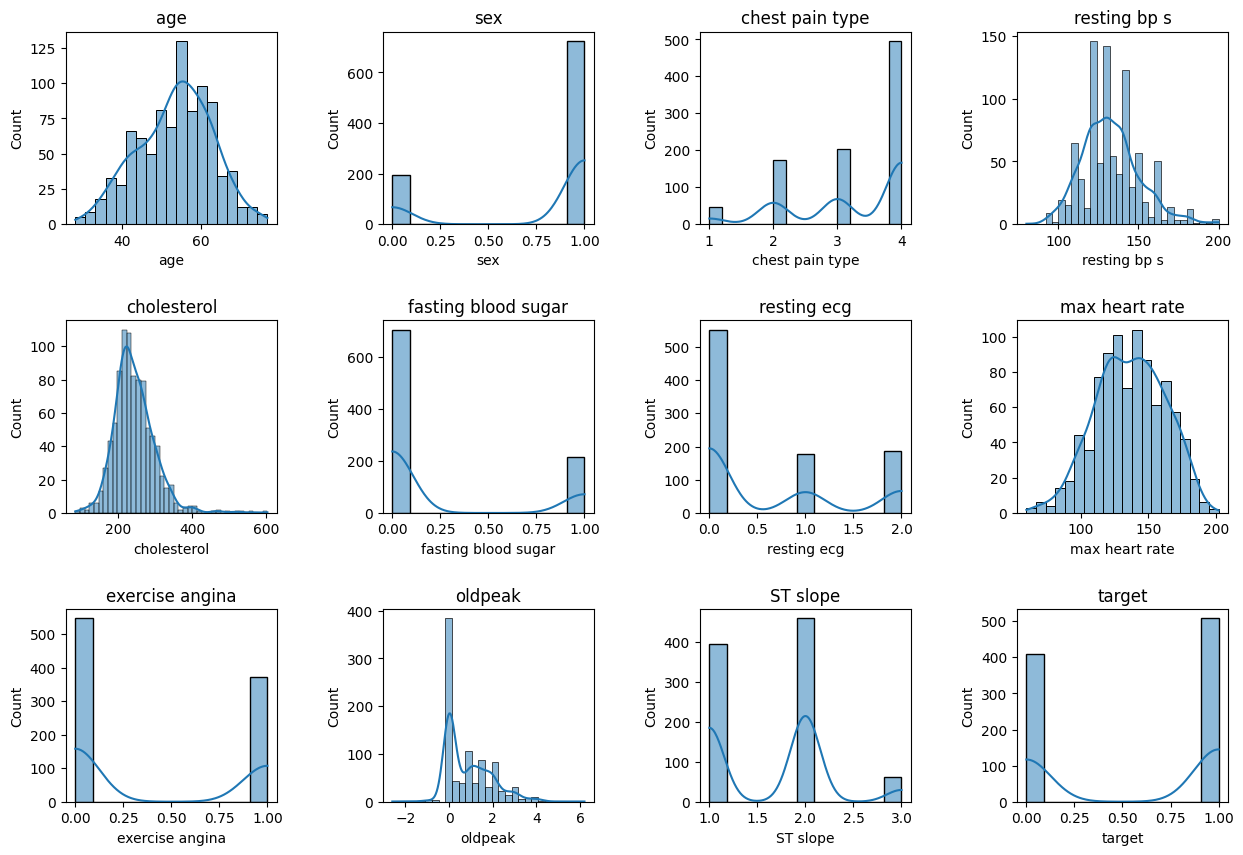

In [278]:
# Kiểm tra phân phối các thuộc tính
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))  # 3 dòng và 4 cột
fig.subplots_adjust(wspace=0.5, hspace=0.5)  # Điều chỉnh khoảng cách giữa các biểu đồ

# Lặp qua các cột của dữ liệu
for i, column in enumerate(data.columns):
    row = i // 4  # Xác định chỉ số dòng (3 dòng)
    col = i % 4   # Xác định chỉ số cột (4 cột)
    sns.histplot(data=data[column], ax=axs[row, col], kde=True)
    axs[row, col].set_title(column)

plt.show()

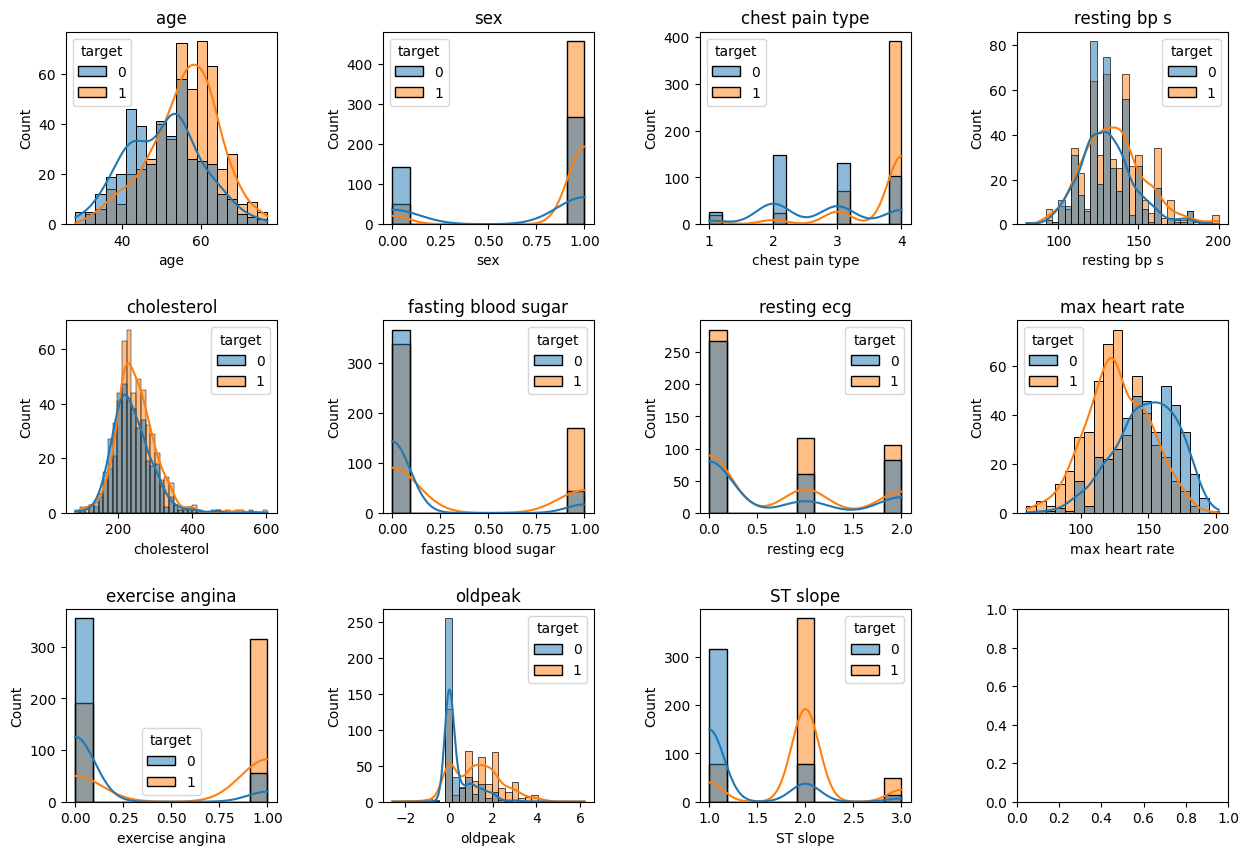

In [279]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, column in enumerate(data.columns):
    if column != 'target':
        row = i // 4
        col = i % 4
        sns.histplot(data=data, x=column, ax=axs[row, col], hue="target", kde=True)
        axs[row, col].set_title(column)
plt.show()

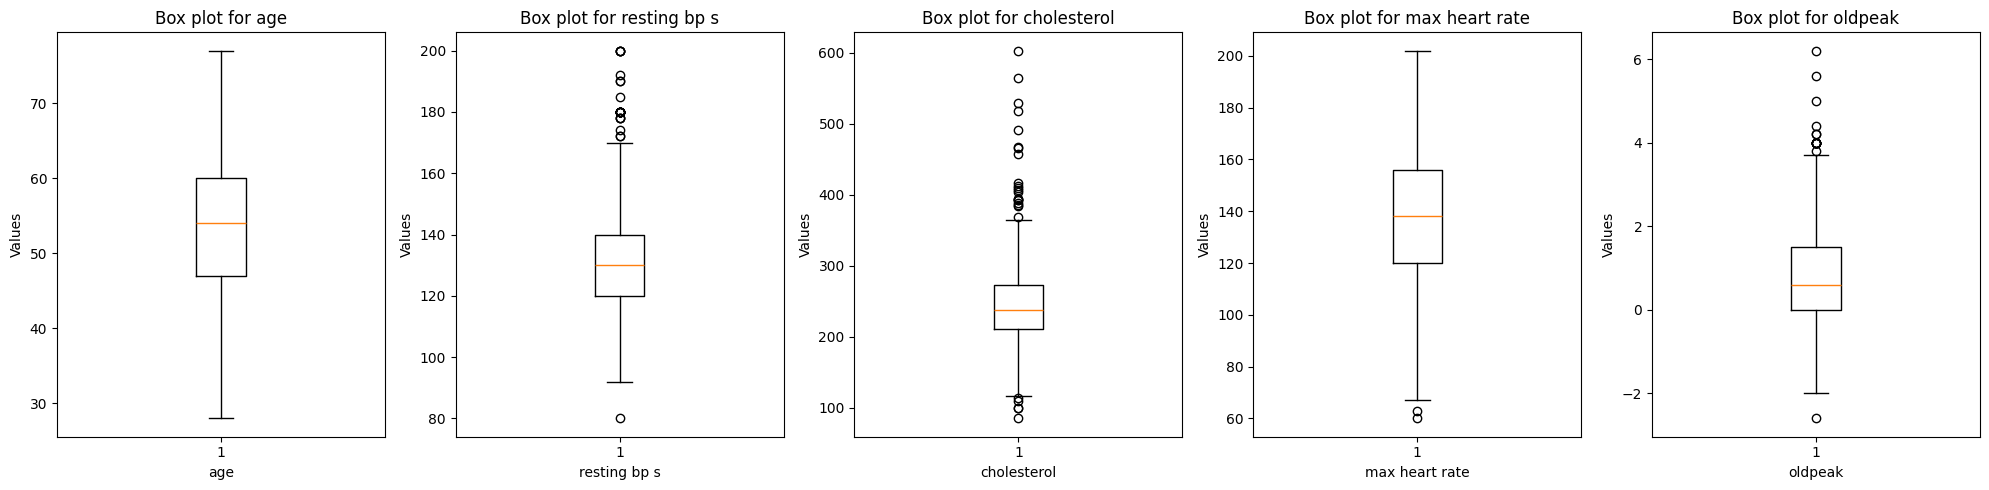

In [280]:
# Kiểm tra outliers với box plot
# Danh sách các feature kiểu numeric
numerical_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# Tạo figure và các subplot trên cùng một hàng
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 5))

# Vẽ các box plot
for i, column in enumerate(numerical_cols):
    axes[i].boxplot(data[column])
    axes[i].set_title(f'Box plot for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Values')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [281]:
# Loại bỏ outlier của cột max heart rate, resting bp s, cholesterol, oldpeak bằng pp IQR
def remove_outliers_iqr(df, cols):
    """
    Loại bỏ outliers trong các cột bằng phương pháp IQR.

    Parameters:
        df (pd.DataFrame): input df
        cols (list): cols để thực hiện loại bỏ outliers

    Returns:
        pd.DataFrame: df sau khi loại bỏ outliers
    """
    df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]
        print(f"{col}: removed {before - after} outlier(s)")
    return df

In [282]:
cols_to_remove = ['max heart rate', 'resting bp s', 'cholesterol', 'oldpeak']
data = remove_outliers_iqr(data, cols_to_remove)
data.info()

max heart rate: removed 2 outlier(s)
resting bp s: removed 27 outlier(s)
cholesterol: removed 27 outlier(s)
oldpeak: removed 13 outlier(s)
<class 'pandas.core.frame.DataFrame'>
Index: 849 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  849 non-null    int64  
 1   sex                  849 non-null    int64  
 2   chest pain type      849 non-null    int64  
 3   resting bp s         849 non-null    int64  
 4   cholesterol          849 non-null    int64  
 5   fasting blood sugar  849 non-null    int64  
 6   resting ecg          849 non-null    int64  
 7   max heart rate       849 non-null    int64  
 8   exercise angina      849 non-null    int64  
 9   oldpeak              849 non-null    float64
 10  ST slope             849 non-null    int64  
 11  target               849 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


Sau khi loại bỏ outliers, dữ liệu còn 849 mẫu

In [293]:
# kiểm tra sự cân bằng dữ liệu
heart_target = data["target"].value_counts()
heart_target

,count
target,
1,460
0,389


 Dữ liệu cân bằng nghĩa là cột target của class A và B nên theo tỷ lệ 50:50 hoặc 60:40. Khi tỷ lệ class A và B là 80:20 hay 90:10 thì được coi là không cân bằng. Việc dữ liệu cân bằng sẽ giúp việc huấn luyện mô hình chính xác hơn, tránh trường hợp overfitting
-> NX: dữ liệu khá cân bằng

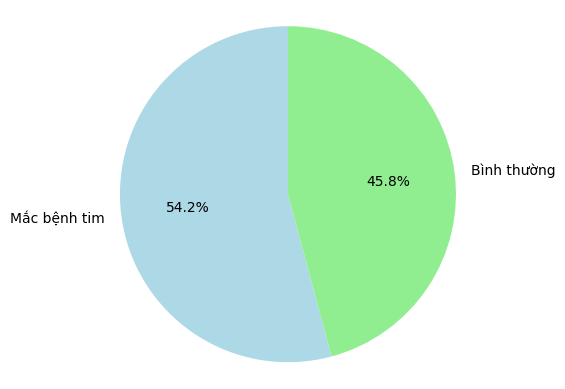

In [294]:
labels = ['Mắc bệnh tim', 'Bình thường']
sizes = heart_target

# Tạo biểu đồ tròn
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])

# Hiển thị biểu đồ tròn
plt.axis('equal')
plt.show()

### Phân tích tương quan

Dùng tương quan Pearson đo lường mối quan hệ tuyến tính giữa các biến numeric

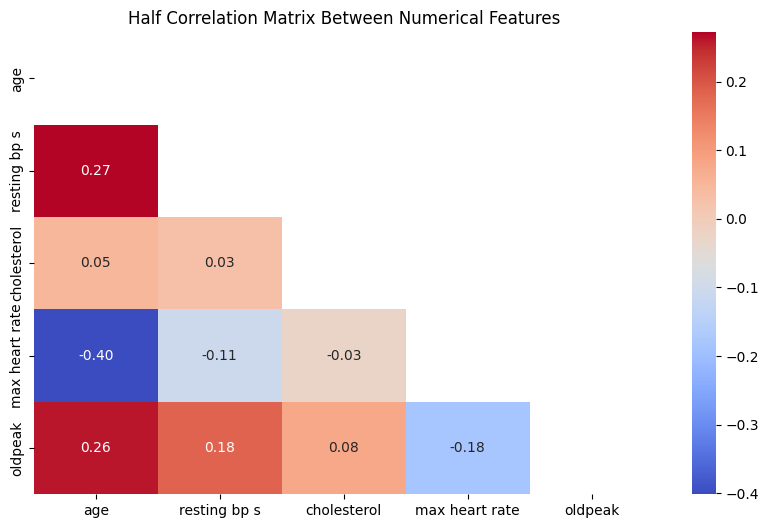

In [299]:
correlation_matrix = data[numerical_cols].corr()
# Tạo một mask để chỉ hiển thị nửa dưới của ma trận
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Half Correlation Matrix Between Numerical Features')
plt.show()

Các hệ số tương quan đều thấp (|r| < 0.5), cho thấy không có hiện tượng đa cộng tuyến (multicollinearity).

Dùng tương quan Point Biserial cho numeric features và biến target - nhị phân

In [302]:
results = {}
for col in numerical_cols:
    r_pb, p_value = pointbiserialr(data[col], data["target"])
    results[col] = {'r_pb': r_pb, 'p_value': p_value}

# Hiển thị kết quả dưới dạng DataFrame
results_df = pd.DataFrame(results).T
results_df.columns = ['Point Biserial Correlation', 'P-value']

# Xuất kết quả
print("Point Biserial Correlation Between Numeric Features And Target:")
print(results_df)

Point Biserial Correlation Between Numeric Features And Target:
                Point Biserial Correlation       P-value
age                               0.291584  4.219755e-18
resting bp s                      0.109721  1.364944e-03
cholesterol                       0.124612  2.728972e-04
max heart rate                   -0.413027  2.617873e-36
oldpeak                           0.413643  2.015194e-36


nhận xét: các p.value đều nhỏ cho thấy các biến có sự tương quan với biến target, nhưng oldpeak, max heart rate cho thấy sự tương quan mạnh, còn age cho thấy sự tương quan nhẹ

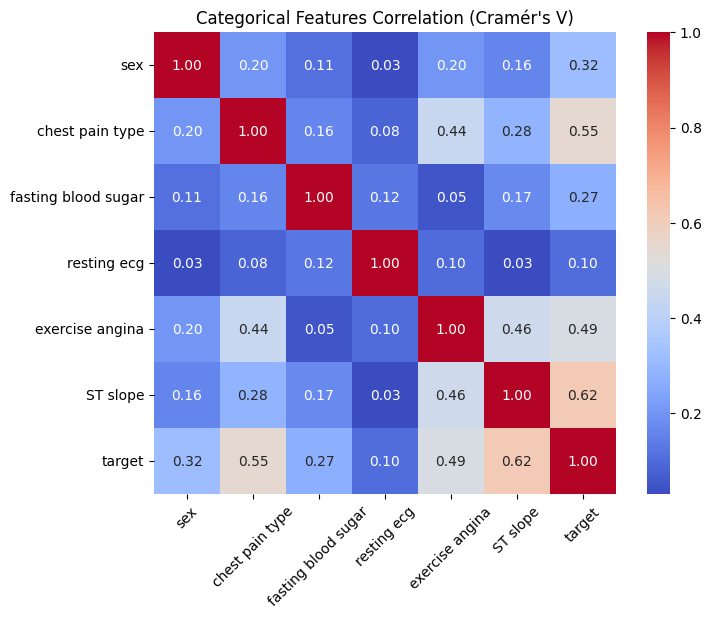

In [303]:
# tương quan giữa các biến categorical
# Hàm tính Cramér's V
def cramerV(label, x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    try:
        if min((kcorr - 1), (rcorr - 1)) == 0:
            return 0
        else:
            return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    except:
        return 0

# Hàm vẽ heatmap Cramér's V
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                cramer.loc[col1, col2] = 1.0
            else:
                cramer.loc[col1, col2] = cramerV(df[col1], df[col2])
    cramer = cramer.astype(float)

    # Vẽ heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cramer, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True
    )
    plt.title("Categorical Features Correlation (Cramér's V)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
categorical_cols = ['sex', 'chest pain type', 'fasting blood sugar',
                    'resting ecg', 'exercise angina', 'ST slope', 'target']
categorical_df = data[categorical_cols]  # Chọn các biến phân loại từ DataFrame
plot_cramer(categorical_df)

st_slope, chest pain type, exercise angina có tương quan mạnh với target, cho thấy chúng có thể có vao trò quan trọng trong dự đoán

### Phân tích một số cột thuộc tính vs target

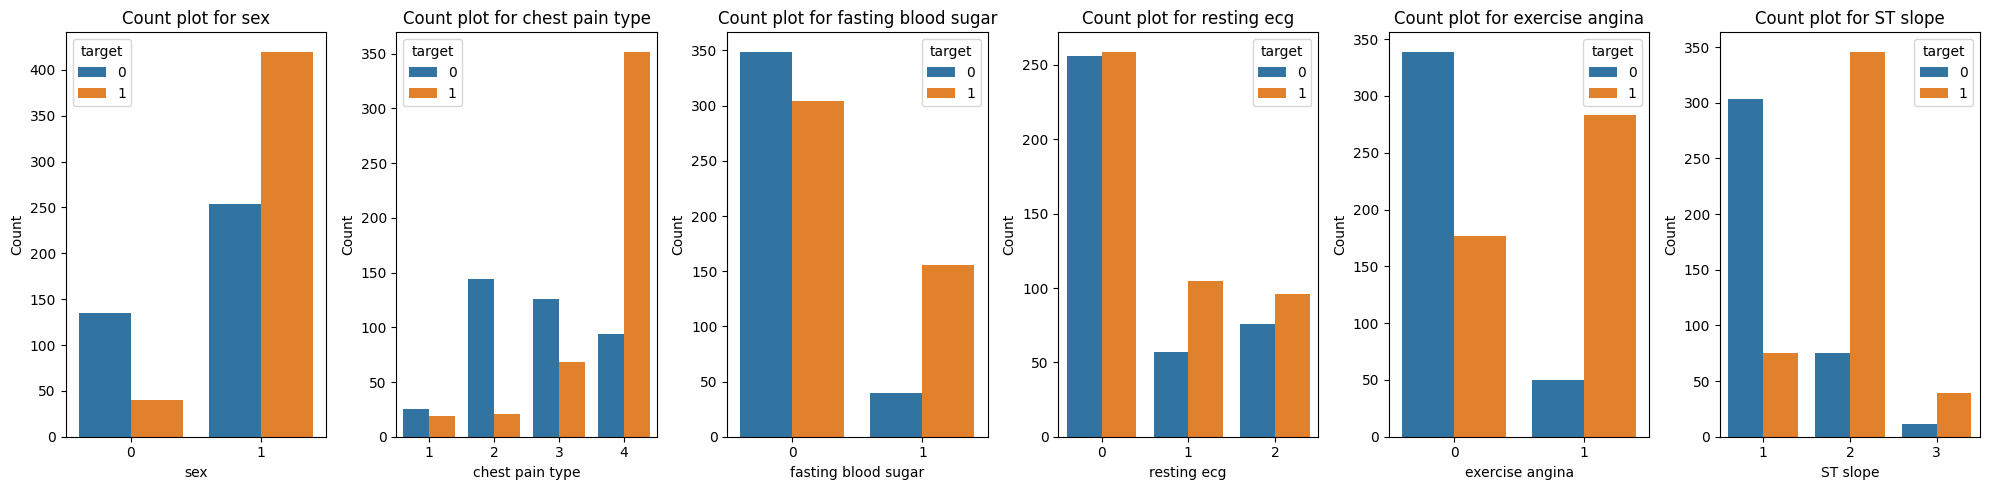

In [304]:
# phân tích 2 biến
categorical_cols = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(20, 5))
for i, column in enumerate(categorical_cols):
    sns.countplot(data=data, x=column, hue='target' , ax=axes[i])
    axes[i].set_title(f'Count plot for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

<ipython-input-305-cd57a6d0a4a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_data['target'] = data['target']


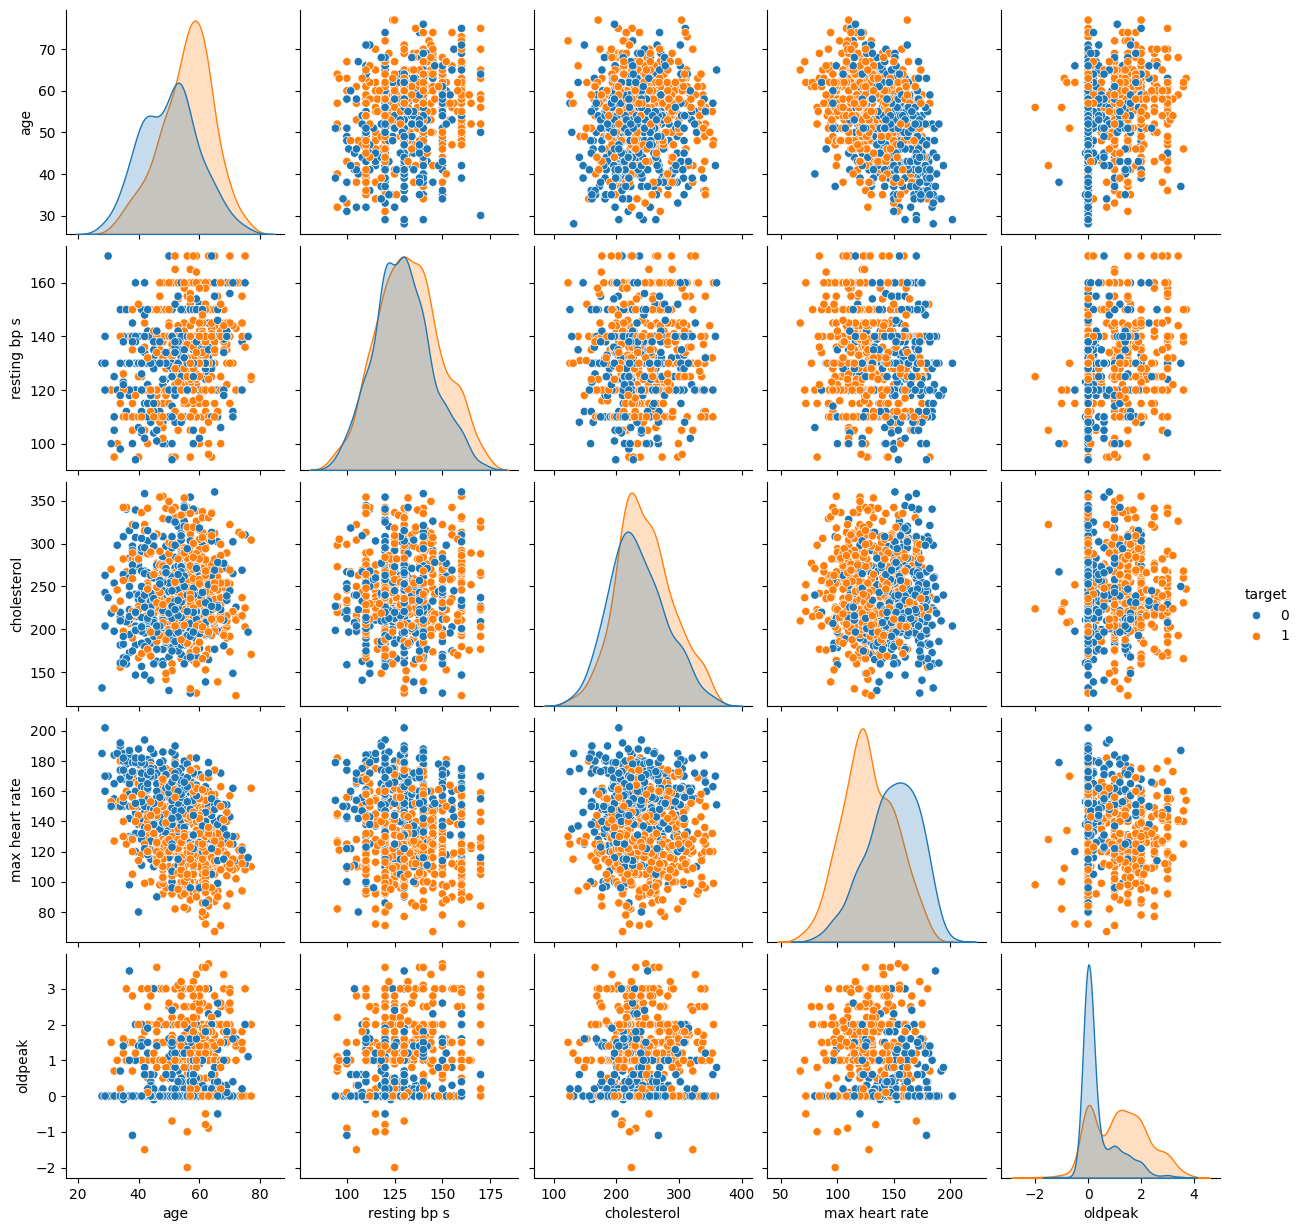

In [305]:
# Dữ liệu liên tục
numerical_data = data[numerical_cols]
numerical_data['target'] = data['target']
sns.pairplot(numerical_data, hue= 'target')
plt.show()

### Data normalization

In [308]:
# one-hot encoding
data= pd.get_dummies(data, columns=categorical_cols)
# data= data.astype(int)
# Chỉ chuyển các cột boolean sang int (0 hoặc 1)
data[data.columns[data.dtypes == 'bool']] = data[data.columns[data.dtypes == 'bool']].astype(int)
data.head()

,age,resting bp s,cholesterol,max heart rate,oldpeak,target,sex_0,sex_1,chest pain type_1,chest pain type_2,...,fasting blood sugar_0,fasting blood sugar_1,resting ecg_0,resting ecg_1,resting ecg_2,exercise angina_0,exercise angina_1,ST slope_1,ST slope_2,ST slope_3
0,40,140,289,172,0.0,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,0
1,49,160,180,156,1.0,1,1,0,0,0,...,1,0,1,0,0,1,0,0,1,0
2,37,130,283,98,0.0,0,0,1,0,1,...,1,0,0,1,0,1,0,1,0,0
3,48,138,214,108,1.5,1,1,0,0,0,...,1,0,1,0,0,0,1,0,1,0
4,54,150,195,122,0.0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0


## Data splitting

In [309]:
# X,y, chia dữ liệu
X = data.drop('target', axis=1)
y = data['target']

In [310]:
X

,age,resting bp s,cholesterol,max heart rate,oldpeak,sex_0,sex_1,chest pain type_1,chest pain type_2,chest pain type_3,...,fasting blood sugar_0,fasting blood sugar_1,resting ecg_0,resting ecg_1,resting ecg_2,exercise angina_0,exercise angina_1,ST slope_1,ST slope_2,ST slope_3
0,40,140,289,172,0.0,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
1,49,160,180,156,1.0,1,0,0,0,1,...,1,0,1,0,0,1,0,0,1,0
2,37,130,283,98,0.0,0,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
3,48,138,214,108,1.5,1,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
4,54,150,195,122,0.0,0,1,0,0,1,...,1,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,110,264,132,1.2,0,1,1,0,0,...,1,0,1,0,0,1,0,0,1,0
1186,68,144,193,141,3.4,0,1,0,0,0,...,0,1,1,0,0,1,0,0,1,0
1187,57,130,131,115,1.2,0,1,0,0,0,...,1,0,1,0,0,0,1,0,1,0
1188,57,130,236,174,0.0,1,0,0,1,0,...,1,0,0,0,1,1,0,0,1,0


In [311]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,age,resting bp s,cholesterol,max heart rate,oldpeak,sex_0,sex_1,chest pain type_1,chest pain type_2,chest pain type_3,...,fasting blood sugar_0,fasting blood sugar_1,resting ecg_0,resting ecg_1,resting ecg_2,exercise angina_0,exercise angina_1,ST slope_1,ST slope_2,ST slope_3
360,53,105,210,115,0.0,0,1,0,0,1,...,1,0,1,0,0,1,0,0,1,0
417,63,140,260,112,3.0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
307,55,115,245,155,0.1,0,1,0,0,0,...,0,1,1,0,0,1,0,0,1,0
2,37,130,283,98,0.0,0,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
253,61,125,292,115,0.0,0,1,0,0,0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,35,140,167,150,0.0,1,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
117,59,130,338,130,1.5,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
296,61,105,304,110,1.5,0,1,0,0,0,...,0,1,1,0,0,0,1,1,0,0
471,53,126,208,106,0.0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,1,0


In [312]:
from sklearn.preprocessing import StandardScaler
# chuẩn hóa dữ liệu (với cột giá trị thực - StandardScaler, với cột biến categorical - one-hot encoding)
columns_to_scale = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
scaler = StandardScaler()
# Chuẩn hóa các cột giá trị thực trong tập huấn luyện
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
# Chuẩn hóa các cột giá trị thực trong tập kiểm tra (sử dụng các tham số từ tập huấn luyện)
X_test_scaled = scaler.transform(X_test[columns_to_scale])
# Sau khi chuẩn hóa, gán lại các cột đã chuẩn hóa vào X_train và X_test
X_train[columns_to_scale] = X_train_scaled
X_test[columns_to_scale] = X_test_scaled

## Build Model

### KNN


In [363]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy (KNN):", accuracy_score(y_test, y_pred))
print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred))
print("Classification Report (KNN):\n", classification_report(y_test, y_pred))

Accuracy (KNN): 0.8647058823529412
Confusion Matrix (KNN):
 [[58 10]
 [13 89]]
Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.82      0.85      0.83        68
           1       0.90      0.87      0.89       102

    accuracy                           0.86       170
   macro avg       0.86      0.86      0.86       170
weighted avg       0.87      0.86      0.87       170



In [364]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Khởi tạo GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv)

# Tìm kiếm tham số tối ưu
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters for KNN:", grid_search.best_params_)

# Sử dụng mô hình tốt nhất để dự đoán
best_knn = grid_search.best_estimator_
y_pred_tuned_knn = best_knn.predict(X_test)

# Đánh giá mô hình sau tinh chỉnh
print("Accuracy (Tuned KNN):", accuracy_score(y_test, y_pred_tuned_knn))
print("Classification Report (Tuned KNN):\n", classification_report(y_test, y_pred_tuned_knn))
print("Confusion Matrix (Tuned KNN):\n", confusion_matrix(y_test, y_pred_tuned_knn))

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy (Tuned KNN): 0.8647058823529412
Classification Report (Tuned KNN):
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        68
           1       0.88      0.89      0.89       102

    accuracy                           0.86       170
   macro avg       0.86      0.86      0.86       170
weighted avg       0.86      0.86      0.86       170

Confusion Matrix (Tuned KNN):
 [[56 12]
 [11 91]]


vẽ learning curve để kiểm tra vấn đề bias cao (underfitting) hoặc variance cao (overfitting)


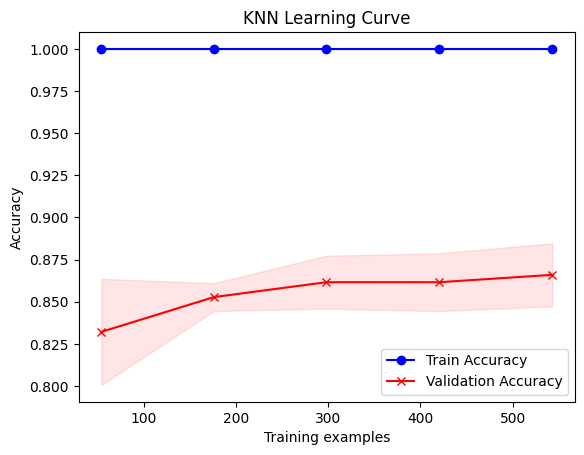

In [365]:
from sklearn.model_selection import learning_curve
knn_best = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
train_sizes = np.linspace(0.1, 1.0, 5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    knn_best, X_train, y_train, train_sizes=train_sizes, cv=cv)
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

train_scores_std = np.std(train_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


fig, ax = plt.subplots()
ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Train Accuracy')
ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation Accuracy')

ax.fill_between(train_sizes, mean_train_scores - train_scores_std, mean_train_scores + train_scores_std, color='blue', alpha=0.1)
ax.fill_between(train_sizes, mean_valid_scores - valid_scores_std, mean_valid_scores + valid_scores_std, color='red', alpha=0.1)

ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("KNN Learning Curve")
ax.legend()

plt.show()

### Decision Tree

In [366]:
from sklearn.tree import DecisionTreeClassifier
# Khởi tạo mô hình Cây quyết định
dt = DecisionTreeClassifier(random_state = 42)

# Huấn luyện mô hình
dt.fit(X_train, y_train)

# Dự đoán kết quả
y_pred_dt = dt.predict(X_test)

# Đánh giá mô hình
print("Accuracy (Decision Tree):", accuracy_score(y_test, y_pred_dt))
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix (Decision Tree):\n", confusion_matrix(y_test, y_pred_dt))

Accuracy (Decision Tree): 0.7941176470588235
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.71      0.81      0.76        68
           1       0.86      0.78      0.82       102

    accuracy                           0.79       170
   macro avg       0.79      0.80      0.79       170
weighted avg       0.80      0.79      0.80       170

Confusion Matrix (Decision Tree):
 [[55 13]
 [22 80]]


In [367]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75]  # Các giá trị cho max_features
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, cv=cv)

grid_search.fit(X_train, y_train)

print("Best parameters for Decision Tree:")
print(grid_search.best_params_)

best_dt = grid_search.best_estimator_
y_pred_tuned_decision_tree = best_dt.predict(X_test)

# Đánh giá mô hình sau tinh chỉnh
print("Accuracy (Tuned Decision Tree):", accuracy_score(y_test, y_pred_tuned_decision_tree))
print("Classification Report (Tuned Decision Tree):\n", classification_report(y_test, y_pred_tuned_decision_tree))
print("Confusion Matrix (Tuned Decision Tree):\n", confusion_matrix(y_test, y_pred_tuned_decision_tree))

Best parameters for Decision Tree:
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy (Tuned Decision Tree): 0.8352941176470589
Classification Report (Tuned Decision Tree):
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        68
           1       0.87      0.85      0.86       102

    accuracy                           0.84       170
   macro avg       0.83      0.83      0.83       170
weighted avg       0.84      0.84      0.84       170

Confusion Matrix (Tuned Decision Tree):
 [[55 13]
 [15 87]]


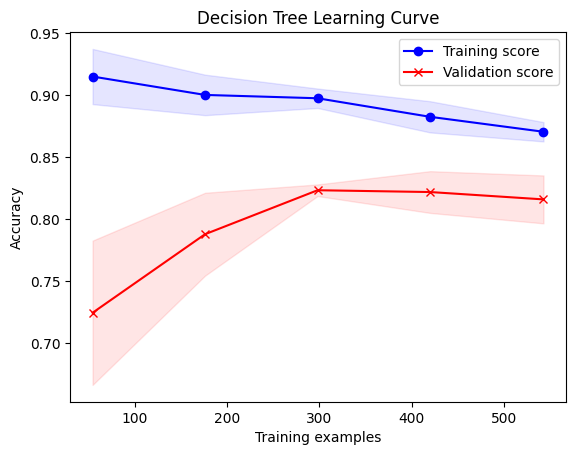

In [332]:
tree_best = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state = 42)
train_sizes, train_scores, valid_scores = learning_curve(
    tree_best,X_train,y_train,train_sizes=train_sizes, cv = cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Vẽ biểu đồ
fig, ax = plt.subplots()
ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Training score')
ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation score')

# Thêm đường bao (standard deviation)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

ax.fill_between(train_sizes, mean_train_scores - train_std, mean_train_scores + train_std, alpha=0.1, color='blue')
ax.fill_between(train_sizes, mean_valid_scores - valid_std, mean_valid_scores + valid_std, alpha=0.1, color='red')

ax.set_title("Decision Tree Learning Curve")
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.legend(loc='best')

plt.show()

### Hồi quy Logistic

In [368]:
from sklearn.linear_model import LogisticRegression

# Khởi tạo mô hình hồi quy logistic
model = LogisticRegression(max_iter=1000, random_state = 42)  # max_iter tăng lên để đảm bảo hội tụ
# Huấn luyện mô hình trên tập huấn luyện
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [369]:
# Dự đoán trên tập kiểm tra
y_pred_logistic = model.predict(X_test)

In [370]:
labels = ['Healthy', 'Diagnosed']

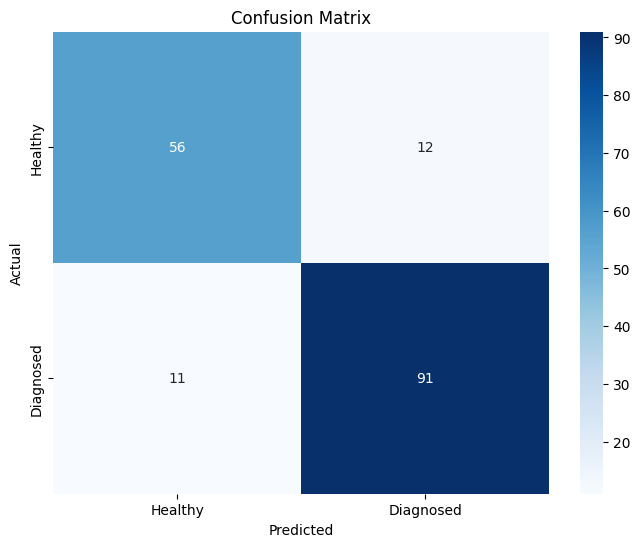

In [371]:
conf_matrix = confusion_matrix(y_test, y_pred_logistic)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [372]:
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        68
           1       0.88      0.89      0.89       102

    accuracy                           0.86       170
   macro avg       0.86      0.86      0.86       170
weighted avg       0.86      0.86      0.86       170



ROC-AUC: 0.92


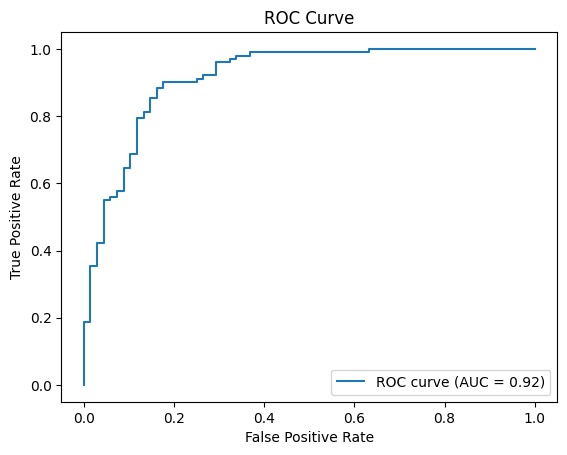

In [373]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Tính xác suất dự đoán cho lớp 1
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Tính chỉ số ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.2f}")

# Vẽ đường cong ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [374]:
param_grid_logistic = {
    'C': [0.1, 1, 10, 100],  # Thử các giá trị khác nhau cho C
    'max_iter': [100, 500, 1000],  # Số vòng lặp tối đa
}

grid_search_logistic = GridSearchCV(LogisticRegression(), param_grid_logistic, cv=cv, n_jobs=-1)

# Tìm kiếm tham số tối ưu
grid_search_logistic.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters for Logistic Regression:", grid_search_logistic.best_params_)

# Sử dụng mô hình tốt nhất để dự đoán
best_logistic = grid_search_logistic.best_estimator_
y_pred_tuned_logistic = best_logistic.predict(X_test)

# Đánh giá mô hình sau tinh chỉnh
print("Accuracy (Tuned Logistic Regression):", accuracy_score(y_test, y_pred_tuned_logistic))
print("Classification Report (Tuned Logistic Regression):\n", classification_report(y_test, y_pred_tuned_logistic))
print("Confusion Matrix (Tuned Logistic Regression):\n", confusion_matrix(y_test, y_pred_tuned_logistic))

Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100}
Accuracy (Tuned Logistic Regression): 0.8705882352941177
Classification Report (Tuned Logistic Regression):
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        68
           1       0.89      0.89      0.89       102

    accuracy                           0.87       170
   macro avg       0.87      0.87      0.87       170
weighted avg       0.87      0.87      0.87       170

Confusion Matrix (Tuned Logistic Regression):
 [[57 11]
 [11 91]]


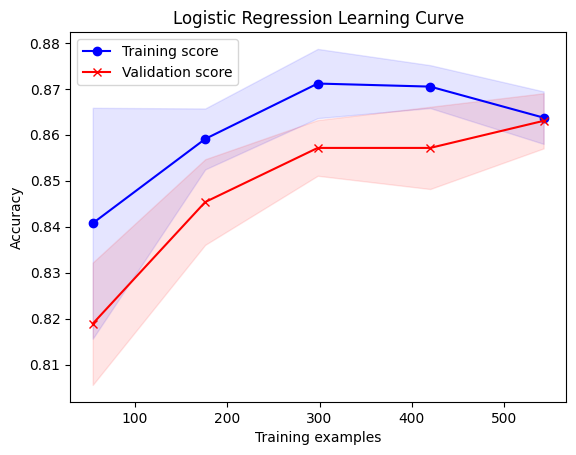

In [375]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_logistic, X_train, y_train, train_sizes=train_sizes, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Vẽ learning curve
# Tính giá trị trung bình của train_scores và valid_scores
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Training score')
ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation score')

# Thêm đường bao (standard deviation)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

ax.fill_between(train_sizes, mean_train_scores - train_std, mean_train_scores + train_std, alpha=0.1, color='blue')
ax.fill_between(train_sizes, mean_valid_scores - valid_std, mean_valid_scores + valid_std, alpha=0.1, color='red')

ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("Logistic Regression Learning Curve")
ax.legend(loc='best')
plt.show()

### SVM


In [376]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy (SVM): {accuracy_svm:.2f}')

Accuracy (SVM): 0.86


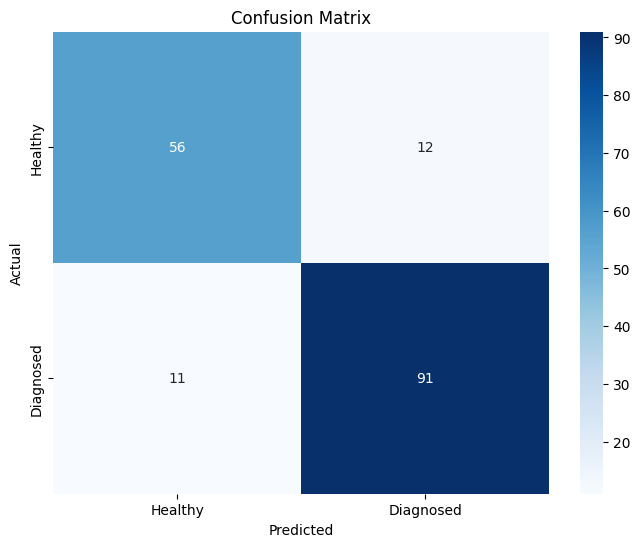

In [377]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [378]:
class_report_svm = classification_report(y_test, y_pred_svm)
print('Classification Report (SVM):\n', class_report_svm)

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.84      0.79      0.82        68
           1       0.87      0.90      0.88       102

    accuracy                           0.86       170
   macro avg       0.86      0.85      0.85       170
weighted avg       0.86      0.86      0.86       170



In [379]:
param_grid_svm = {
    'C': [0.1, 1, 10],  # Thử các giá trị khác nhau cho C
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Thử các kiểu kernel khác nhau
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Thử các giá trị khác nhau cho gamma
    'degree': [3, 4, 5],  # Chỉ áp dụng cho kernel 'poly', thử các giá trị khác nhau cho degree
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=cv)
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters for SVM found: {grid_search_svm.best_params_}")
# print(f"Best cross-validation score (SVM): {grid_search_svm.best_score_:.2f}")

# Dự đoán với mô hình SVM đã tinh chỉnh
best_svm_model = grid_search_svm.best_estimator_
y_pred_tuned_svm = best_svm_model.predict(X_test)

# Đánh giá mô hình SVM đã tinh chỉnh
accuracy_svm_tuned = accuracy_score(y_test, y_pred_tuned_svm)
print(f'Accuracy (Tuned SVM): {accuracy_svm_tuned:.4f}')

# Confusion Matrix for tuned SVM
conf_matrix_svm_tuned = confusion_matrix(y_test, y_pred_tuned_svm)
print('Confusion Matrix (Tuned SVM):\n', conf_matrix_svm_tuned)

# Classification Report for tuned SVM
class_report_svm_tuned = classification_report(y_test, y_pred_tuned_svm)
print('Classification Report (Tuned SVM):\n', class_report_svm_tuned)

Best parameters for SVM found: {'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy (Tuned SVM): 0.8588
Confusion Matrix (Tuned SVM):
 [[54 14]
 [10 92]]
Classification Report (Tuned SVM):
               precision    recall  f1-score   support

           0       0.84      0.79      0.82        68
           1       0.87      0.90      0.88       102

    accuracy                           0.86       170
   macro avg       0.86      0.85      0.85       170
weighted avg       0.86      0.86      0.86       170



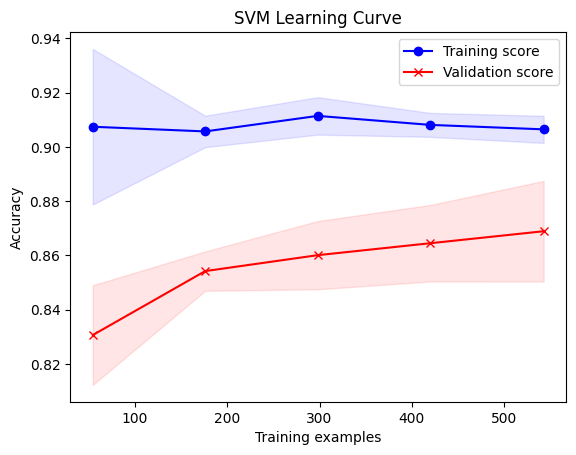

In [380]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_svm_model, X_train, y_train, train_sizes=train_sizes, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Vẽ learning curve
# Tính giá trị trung bình của train_scores và valid_scores
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Vẽ biểu đồ
fig, ax = plt.subplots()
ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Training score')
ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation score')

# Thêm đường bao (standard deviation)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

ax.fill_between(train_sizes, mean_train_scores - train_std, mean_train_scores + train_std, alpha=0.1, color='blue')
ax.fill_between(train_sizes, mean_valid_scores - valid_std, mean_valid_scores + valid_std, alpha=0.1, color='red')

ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("SVM Learning Curve")
ax.legend(loc='best')
plt.show()

###ADABOOST

In [381]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Xây dựng mô hình AdaBoost với một cây quyết định làm base estimator
ada_boost1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)

ada_boost1.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_ada = ada_boost1.predict(X_test)

# Đánh giá mô hình
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy (AdaBoost): {accuracy_ada:.2f}')

# Confusion Matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
print('Confusion Matrix (AdaBoost):\n', conf_matrix_ada)

# Classification Report (Precision, Recall, F1-Score)
class_report_ada = classification_report(y_test, y_pred_ada)
print('Classification Report (AdaBoost):\n', class_report_ada)

Accuracy (AdaBoost): 0.82
Confusion Matrix (AdaBoost):
 [[54 14]
 [16 86]]
Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.77      0.79      0.78        68
           1       0.86      0.84      0.85       102

    accuracy                           0.82       170
   macro avg       0.82      0.82      0.82       170
weighted avg       0.82      0.82      0.82       170



In [382]:
# Định nghĩa mô hình AdaBoost với base estimator là cây quyết định
ada_boost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
param_grid_ada = {
    'estimator__max_depth': [3, 5, 7],  # Tinh chỉnh max_depth của cây quyết định
    'n_estimators': [50, 100, 150, 200],  # Số lượng estimators
    'learning_rate': [0.01, 0.1, 0.5, 1],  # Tốc độ học
}

grid_search_ada = GridSearchCV(ada_boost, param_grid_ada, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

print(f"Best parameters for AdaBoost found: {grid_search_ada.best_params_}")
# print(f"Best cross-validation score (AdaBoost): {grid_search_ada.best_score_:.4f}")

best_ada = grid_search_ada.best_estimator_
# Dự đoán trên tập kiểm tra với tham số tốt nhất
y_pred_tuned_ada = best_ada.predict(X_test)

# Đánh giá mô hình đã tinh chỉnh
accuracy_ada_tuned = accuracy_score(y_test, y_pred_tuned_ada)
print(f'Accuracy (AdaBoost Tuned): {accuracy_ada_tuned:.2f}')

# Confusion Matrix
conf_matrix_ada_tuned = confusion_matrix(y_test, y_pred_tuned_ada)
print('Confusion Matrix (AdaBoost Tuned):\n', conf_matrix_ada_tuned)

# Classification Report (Precision, Recall, F1-Score)
class_report_ada_tuned = classification_report(y_test, y_pred_tuned_ada)
print('Classification Report (AdaBoost Tuned):\n', class_report_ada_tuned)


Best parameters for AdaBoost found: {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 50}
Accuracy (AdaBoost Tuned): 0.82
Confusion Matrix (AdaBoost Tuned):
 [[53 15]
 [16 86]]
Classification Report (AdaBoost Tuned):
               precision    recall  f1-score   support

           0       0.77      0.78      0.77        68
           1       0.85      0.84      0.85       102

    accuracy                           0.82       170
   macro avg       0.81      0.81      0.81       170
weighted avg       0.82      0.82      0.82       170



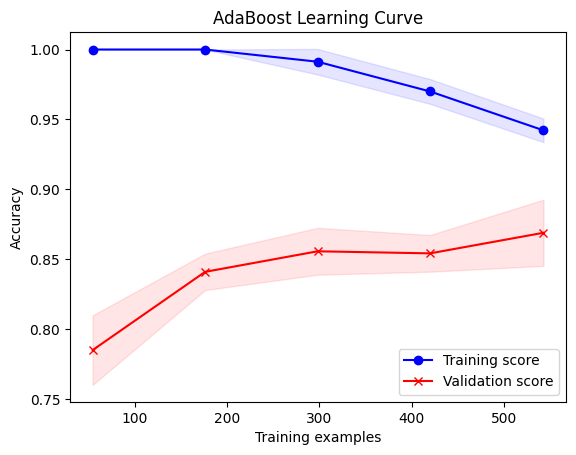

In [383]:
train_sizes, train_scores, valid_scores = learning_curve(
    best_ada, X_train, y_train, train_sizes=train_sizes, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Vẽ learning curve
# Tính giá trị trung bình của train_scores và valid_scores
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Vẽ biểu đồ
fig, ax = plt.subplots()
ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Training score')
ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation score')

# Thêm đường bao (standard deviation)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

ax.fill_between(train_sizes, mean_train_scores - train_std, mean_train_scores + train_std, alpha=0.1, color='blue')
ax.fill_between(train_sizes, mean_valid_scores - valid_std, mean_valid_scores + valid_std, alpha=0.1, color='red')

# Tiêu đề và nhãn
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("AdaBoost Learning Curve")
ax.legend(loc='best')
plt.show()

#SO SÁNH CÁC MÔ HÌNH

In [384]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
)
data = {
    'KNN': y_pred,
    'Decision Tree': y_pred_dt,
    'Logistic Regression': y_pred_logistic,
    'SVM': y_pred_tuned_svm,
    'Adaboost': y_pred_tuned_ada,
}
models = pd.DataFrame(data)
model_results = pd.DataFrame()  # DataFrame lưu kết quả evaluation metrics
for column in models:
    cm = confusion_matrix(y_test, models[column])
    TN, FP = cm[0][0], cm[0][1]
    FN, TP = cm[1][0], cm[1][1]
    specificity = TN/(TN+FP)
    loss_log = log_loss(y_test, models[column])  # Log Loss
    acc = accuracy_score(y_test, models[column])  # Accuracy
    roc = roc_auc_score(y_test, models[column])  # ROC-AUC
    prec = precision_score(y_test, models[column])  # Precision
    rec = recall_score(y_test, models[column])  # Recall
    f1 = f1_score(y_test, models[column])  # F1-Score

    results = pd.DataFrame(
        [[column, acc, prec, rec, specificity, f1, roc, loss_log ]],
        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'ROC', 'Log_Loss']
    )
    model_results = pd.concat([model_results, results], ignore_index=True)

In [385]:
model_results

,Model,Accuracy,Precision,Recall,Specificity,F1 Score,ROC,Log_Loss
0,KNN,0.864706,0.898990,0.872549,0.852941,0.885572,0.862745,4.876494
1,Decision Tree,0.794118,0.860215,0.784314,0.808824,0.820513,0.796569,7.420752
2,Logistic Regression,0.864706,0.883495,0.892157,0.823529,0.887805,0.857843,4.876494
3,SVM,0.858824,0.867925,0.901961,0.794118,0.884615,0.848039,5.088516
4,Adaboost,0.817647,0.851485,0.843137,0.779412,0.847291,0.811275,6.572666


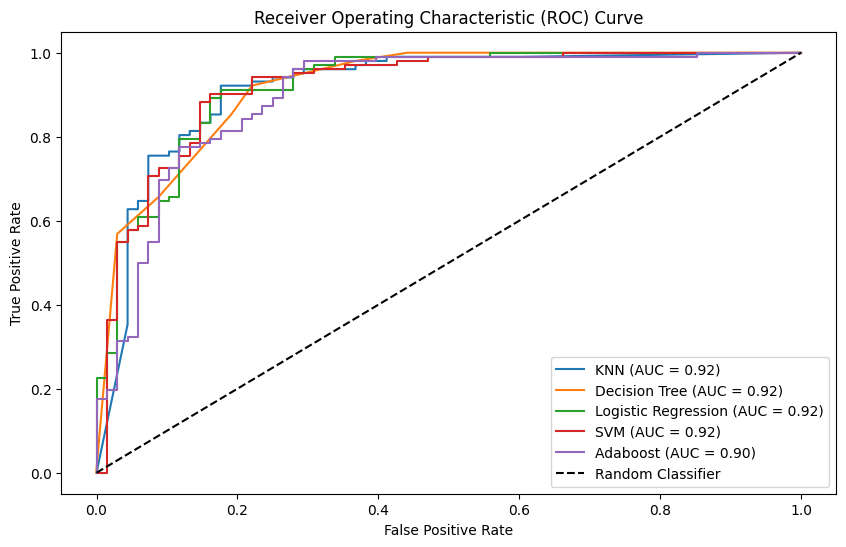

In [386]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 6))
models_dict = {
    'KNN': best_knn,
    'Decision Tree': best_dt,
    'Logistic Regression': best_logistic,
    'SVM': best_svm_model,
    'Adaboost': best_ada ,
}
for model_name, model in models_dict.items():
    # Lấy xác suất cho lớp dương (class 1) từ predict_proba()
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Tính FPR, TPR và thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Tính AUC
    roc_auc = auc(fpr, tpr)

    # Vẽ đường ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Vẽ đường chéo (ngẫu nhiên)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

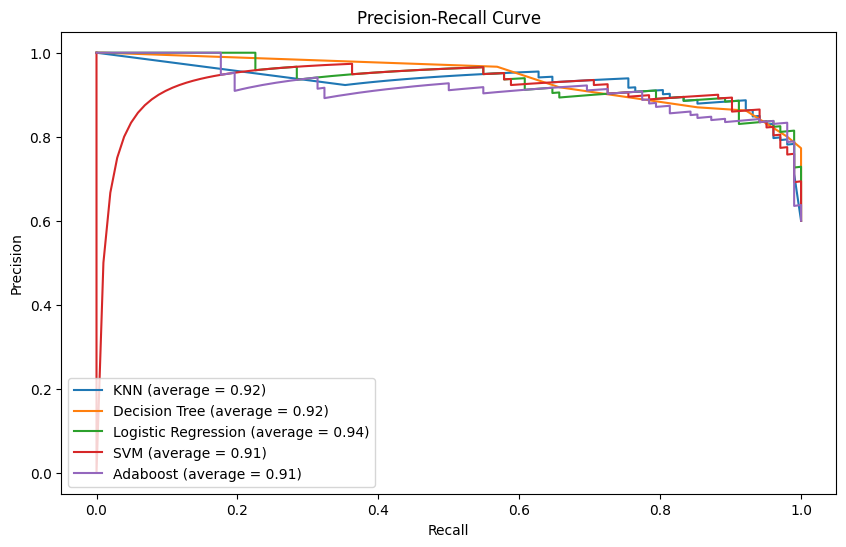

In [394]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 6))
for model_name, model in models_dict.items():
    # Lấy xác suất cho lớp dương (class 1) từ predict_proba()
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Tính precision, recall và thresholds
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # Tính Average Precision (AP)
    average_precision = average_precision_score(y_test, y_pred_prob)

    # Vẽ Precision-Recall Curve
    plt.plot(recall, precision, label=f'{model_name} (average = {average_precision:.2f})')

# Thiết lập các thông số đồ thị
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

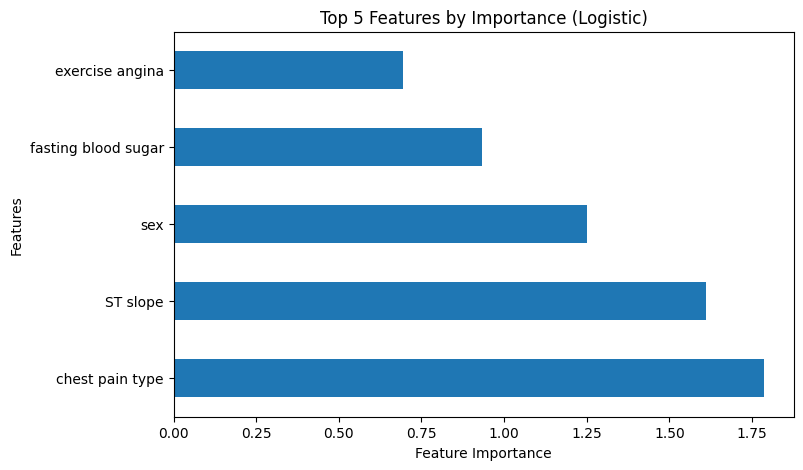

In [402]:
best_logistic = grid_search_logistic.best_estimator_
coefs = np.abs(best_logistic.coef_[0])

feat_importances_logistic = pd.Series(coefs, index=X_train.columns)

# Gom tất cả các feature one-hot encoding về feature gốc
feat_importances_logistic.index = feat_importances_logistic.index.str.replace(r'(.*)_.*', r'\1', regex=True)

feat_importances_logistic = feat_importances_logistic.groupby(level=0).sum()

# Vẽ top 5 đặc trưng quan trọng nhất
plt.figure(figsize=(8, 5))
feat_importances_logistic.nlargest(5).plot(kind='barh')
plt.title('Top 5 Features by Importance (Logistic)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


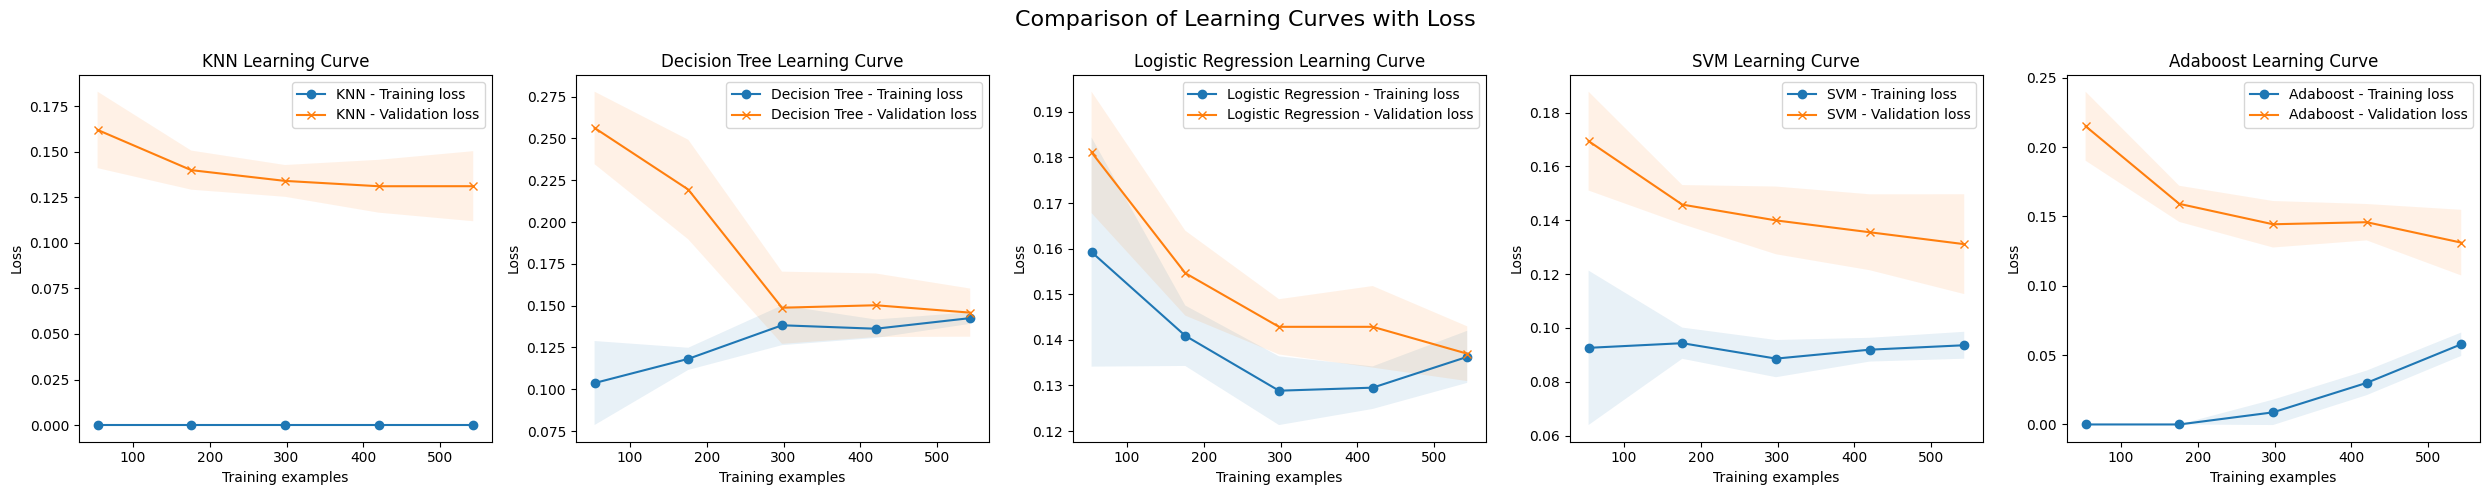

In [399]:
def plot_learning_curves(models, X_train, y_train, cv, train_sizes, title):
    num_models = len(models)

    # Tạo một figure với các subplots trên cùng một hàng
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

    # Chuyển axes thành mảng nếu chỉ có một mô hình
    if num_models == 1:
        axes = [axes]

    # Lặp qua các mô hình và vẽ từng Learning Curve
    for i, (label, model) in enumerate(models.items()):
        # Tính Learning Curve
        train_sizes, train_scores, valid_scores = learning_curve(
            model, X_train, y_train, train_sizes=train_sizes, cv=cv, scoring='neg_mean_squared_error'
        )

        # Tính trung bình và độ lệch chuẩn của loss
        mean_train_loss = -np.mean(train_scores, axis=1)  # Chuyển sang giá trị dương vì dùng neg_mean_squared_error
        mean_valid_loss = -np.mean(valid_scores, axis=1)
        train_std = np.std(-train_scores, axis=1)
        valid_std = np.std(-valid_scores, axis=1)

        # Vẽ đường trung bình của train và validation loss
        axes[i].plot(train_sizes, mean_train_loss, 'o-', label=f'{label} - Training loss')
        axes[i].plot(train_sizes, mean_valid_loss, 'x-', label=f'{label} - Validation loss')

        # Vẽ vùng sai số (standard deviation)
        axes[i].fill_between(train_sizes, mean_train_loss - train_std, mean_train_loss + train_std, alpha=0.1)
        axes[i].fill_between(train_sizes, mean_valid_loss - valid_std, mean_valid_loss + valid_std, alpha=0.1)

        axes[i].set_xlabel("Training examples")
        axes[i].set_ylabel("Loss")
        axes[i].set_title(f"{label} Learning Curve")
        axes[i].legend(loc='best')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_learning_curves(models_dict, X_train, y_train, cv, train_sizes, "Comparison of Learning Curves with Loss")


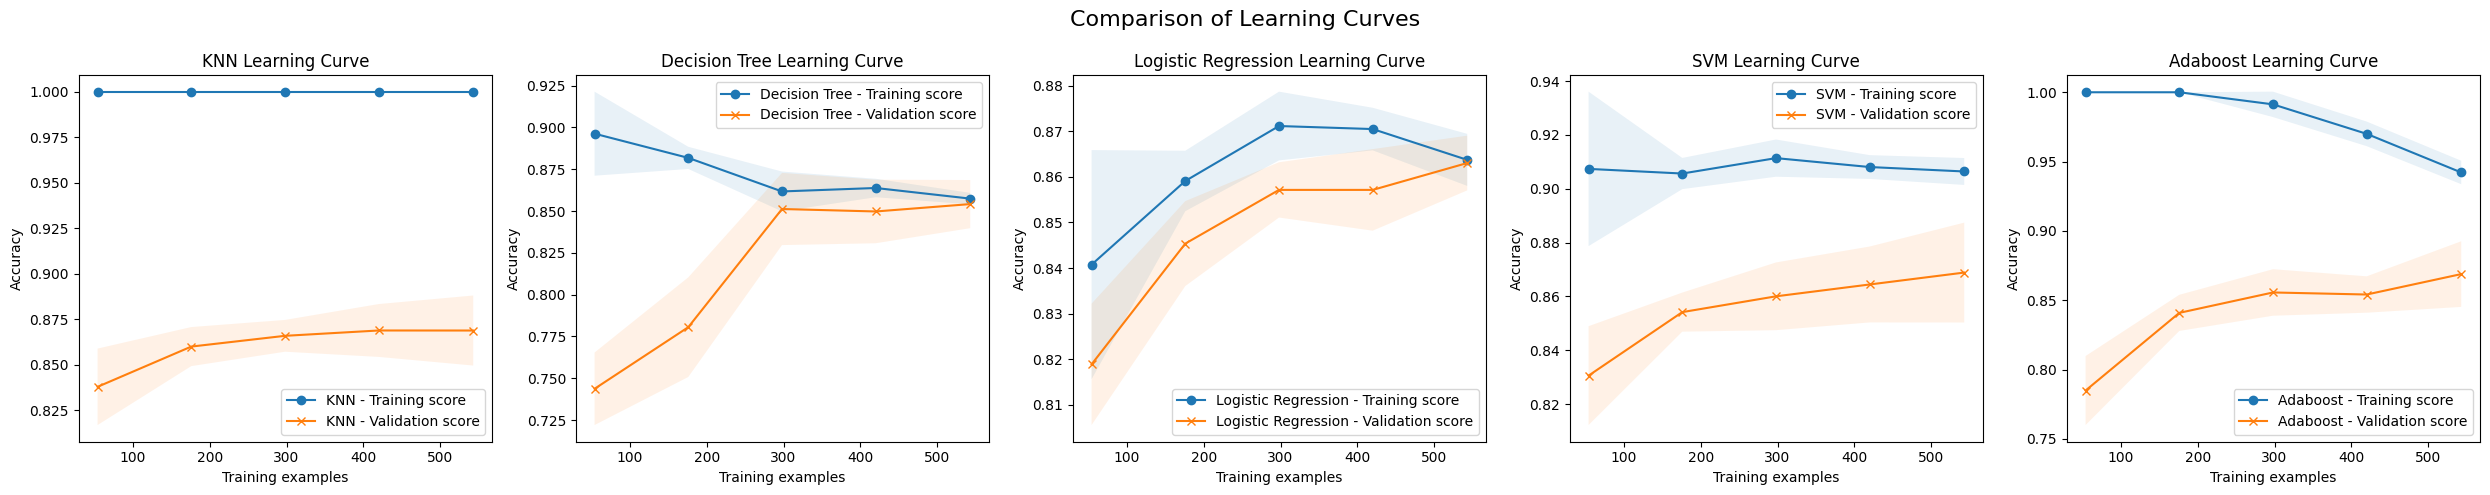

In [390]:
def plot_learning_curves(models, X_train, y_train, cv, train_sizes, title):
    num_models = len(models)

    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

    if num_models == 1:
        axes = [axes]

    for i, (label, model) in enumerate(models.items()):
        train_sizes, train_scores, valid_scores = learning_curve(
            model, X_train, y_train, train_sizes=train_sizes, cv=cv
        )

        mean_train_scores = np.mean(train_scores, axis=1)
        mean_valid_scores = np.mean(valid_scores, axis=1)

        axes[i].plot(train_sizes, mean_train_scores, 'o-', label=f'{label} - Training score')
        axes[i].plot(train_sizes, mean_valid_scores, 'x-', label=f'{label} - Validation score')

        train_std = np.std(train_scores, axis=1)
        valid_std = np.std(valid_scores, axis=1)
        axes[i].fill_between(train_sizes, mean_train_scores - train_std, mean_train_scores + train_std, alpha=0.1)
        axes[i].fill_between(train_sizes, mean_valid_scores - valid_std, mean_valid_scores + valid_std, alpha=0.1)

        axes[i].set_xlabel("Training examples")
        axes[i].set_ylabel("Accuracy")
        axes[i].set_title(f"{label} Learning Curve")
        axes[i].legend(loc='best')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top to fit the suptitle
    plt.show()

plot_learning_curves(models_dict, X_train, y_train, cv, train_sizes, "Comparison of Learning Curves")


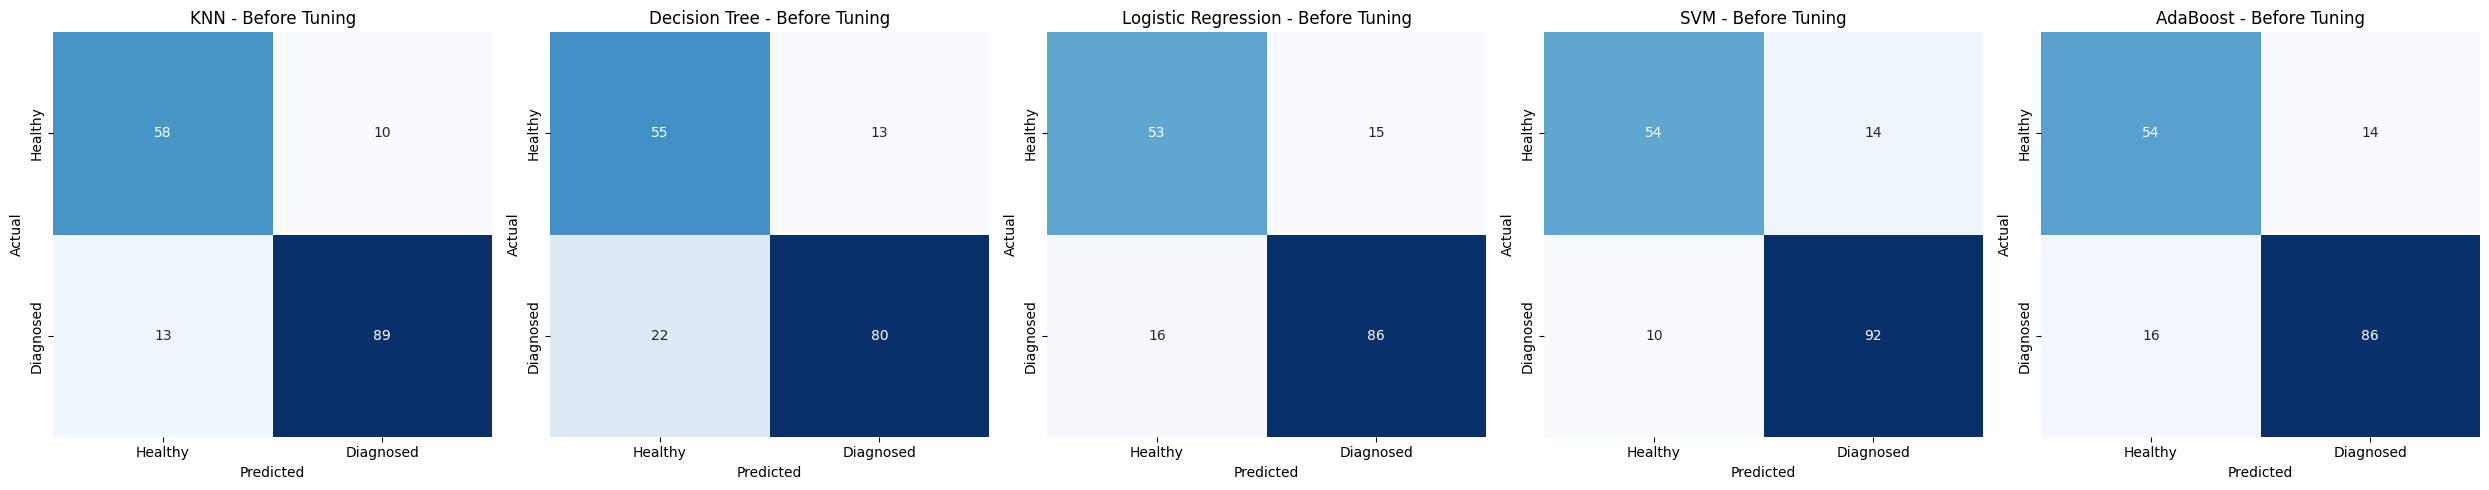

In [400]:
models = {
    "KNN": (knn, best_knn),
    "Decision Tree": (dt, best_dt),
    "Logistic Regression": (model, best_logistic),
    "SVM": (svm, best_svm_model),
    "AdaBoost": (ada_boost1, best_ada),
}

labels = ['Healthy', 'Diagnosed']
# Confusion Matrix trước tinh chỉnh
plt.figure(figsize=(25, 5))
for i, (model_name, (model_before, _)) in enumerate(models.items()):

    # Dự đoán trước tinh chỉnh
    y_pred_before = model_before.predict(X_test)
    conf_matrix_before = confusion_matrix(y_test, y_pred_before)

    # Plot Confusion Matrix trước tinh chỉnh
    plt.subplot(1, len(models), i + 1)
    sns.heatmap(conf_matrix_before, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f"{model_name} - Before Tuning")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


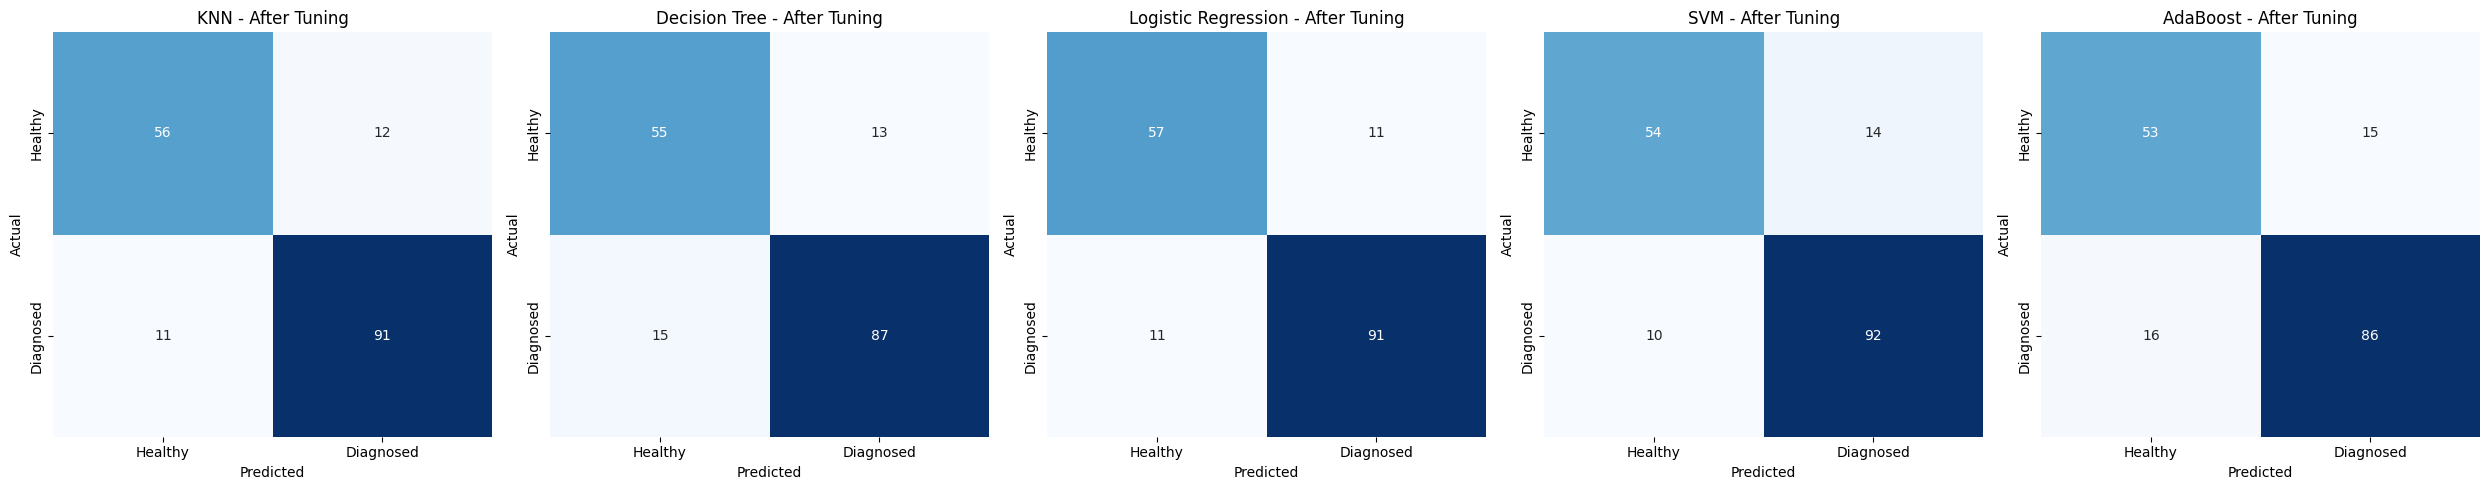

In [401]:
# Confusion Matrix sau tinh chỉnh
plt.figure(figsize=(25, 5))
for i, (model_name, (_, model_after)) in enumerate(models.items()):  # Chỉ sử dụng model_after

    # Dự đoán sau tinh chỉnh
    y_pred_after = model_after.predict(X_test)
    conf_matrix_after = confusion_matrix(y_test, y_pred_after)

    plt.subplot(1, len(models), i + 1)
    sns.heatmap(conf_matrix_after, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f"{model_name} - After Tuning")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [403]:
import pickle

model_filename = 'best_logistic_model.pkl'

# Lưu model
with open(model_filename, 'wb') as file:
    pickle.dump(best_logistic, file)

print('Model Saved Successfully:', model_filename)

Model Saved Successfully: best_logistic_model.pkl
